In [2]:
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Load

In [59]:
# load dataset

label = 0

X = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_train_8features_' + str(0) + '.txt', delimiter=',')

X_test = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_test_8features_' + str(0) + '.txt', delimiter=',')

In [60]:
X.shape[0]

1008

In [61]:
Y = np.zeros((X.shape[0],))
Y[:int(X.shape[0]/2)] = 1
Y[int(X.shape[0]/2):] = -1

Y_test = np.zeros((X_test.shape[0],))
Y_test[:int(X_test.shape[0]/2)] = 1
Y_test[int(X_test.shape[0]/2):] = -1

In [62]:
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)

(1008, 8) (1008,)
(216, 8) (216,)


# Create Quantum Model

In [63]:
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
import numpy
from pennylane.optimize import *

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

## Choose a Quantum Device

You can choose between several different backend (including the one ownwed by IBM)

In [64]:
def select_backend(num_qubit, selected, shots):
    if selected == 'pennylane_statevector_simulator':
        # PennyLane Statevector simulator
        dev = qml.device("default.qubit", wires=num_qubit)

    elif selected == 'qiskit_noisefree_qasm_simulator':
        # Qiskit QASM simulator (noise-free)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, analytic=False, backend='qasm_simulator')

    elif selected == 'qiskit_noisy_qasm_simulator':
        # Qiskit QASM simulator + noise
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
        noise_model = NoiseModel.from_backend(backend)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, noise_model = noise_model, analytic=False, backend='qasm_simulator')
        
    return dev

In [65]:
num_qubit = 3
dev = select_backend(num_qubit, 'pennylane_statevector_simulator', 1024)

## Loss and Acc Metric

In [66]:
# MSE
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# Cost-Sensitive Learning for Imbalanced Classification
def confusion_matrix_loss(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    # calculate loss
    loss = float(np.sum(CM*cost_matrix))/len(labels)

    return loss

# true predictions/total predictions
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

In [163]:
confusion_matrix_loss(Y_train, predictions_train)

0.1

In [164]:
square_loss(Y_train, predictions_train)

0.9032258064516129

In [200]:
cost_matrix = np.array([[0, 0.9], [0.1, 0]])

In [181]:
loss_weight = np.unique(Y, return_counts=True)[1]/np.sum(np.unique(Y, return_counts=True)[1])
loss_weight

array([0.9, 0.1])

## Quantum Amplitude Encoding Function

In [67]:
# a function to calculate the angle β

def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/den)
    
    return beta

In [68]:
def get_angles(x):
    
    return np.array([beta(3,1,x), beta(2,2,x), beta(2,1,x), beta(1,4,x), beta(1,3,x), beta(1,2,x), beta(1,1,x)])

In [69]:
def U3_gate(θ, wires):
    qml.RX(np.pi/2, wires=wires)
    qml.RZ(θ, wires=wires)
    qml.RX(-np.pi/2, wires=wires)

In [70]:
def statepreparation(a):
    qml.RY(a[0], wires=0)
    
    U3_gate(a[1]/2, wires=1)
    qml.CNOT(wires=[0,1])
    U3_gate(-a[1]/2, wires=1)
    qml.CNOT(wires=[0,1])
    
    qml.PauliX(wires=0)
    U3_gate(a[2]/2, wires=1)
    qml.CNOT(wires=[0,1])
    U3_gate(-a[2]/2, wires=1)
    qml.CNOT(wires=[0,1])
    qml.PauliX(wires=0)
    
    U3_gate(a[3]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    U3_gate(-a[3]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    
    qml.PauliX(wires=1)
    U3_gate(a[4]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    U3_gate(-a[4]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    qml.PauliX(wires=1)
    
    qml.PauliX(wires=0)
    U3_gate(a[5]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    U3_gate(-a[5]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    
    qml.PauliX(wires=1)
    U3_gate(a[6]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    U3_gate(-a[6]/2, wires=2)
    qml.Toffoli(wires=[0,1,2])
    qml.PauliX(wires=1)
    
    qml.PauliX(wires=0)

In [71]:
x = np.random.rand(8)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles=None):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(angles=ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev._state))

x               :  [0.85651456 0.01857334 0.25204555 0.90887045 0.41886124 0.8437664
 0.21724143 0.40669399]
angles          :  [1.37735744 0.91036337 1.66679029 2.16038447 2.22003606 2.60055393
 0.0433628 ]
amplitude vector:  [[[0.519003   0.01125447]
  [0.15272641 0.55072793]]

 [[0.25380799 0.51127829]
  [0.13163694 0.24643528]]]


## Define the Layer

In [72]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])

## Build the Quantum Circuit, Define Cost Function, Create VQC

In [86]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

# Data Prep

## Data (Padding), Normalization and Data Encoding

In [74]:
# train and val

print("First X train sample (original)  :", X[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X), 1))
# X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X train sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

First X train sample (original)  : [ 3.96752304 -1.15630211  2.33858651 -1.80692626 -3.24421656 -0.71353148
 -0.17655089 -0.41164546]
First X train sample (normalized): [ 0.65184348 -0.18997445  0.38421765 -0.29686862 -0.53300797 -0.11722953
 -0.0290064  -0.06763122]
First features sample      : [1.16637288 0.26806496 1.24161413 2.33126975 0.43298526 1.31568975
 0.56717374]


In [75]:
sampel = 436

result = 0

for i in range (8):
    result += X_norm[sampel, i]**2

np.sqrt(result)

1.0

In [76]:
print("First X test sample (original)  :", X_test[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X_test), 1))
# X_pad = np.c_[np.c_[X_test, padding], np.zeros((len(X_test), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X_test.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X test sample (normalized):", X_norm[0])

# angles for state preparation are new features
feats_test = np.array([get_angles(x) for x in X_norm])
print("First test features sample      :", feats_test[0])

First X test sample (original)  : [ 4.83885093  0.44290373  0.99533214 -0.38530635 -0.81798657 -1.90399072
  2.72785227  0.29909493]
First X test sample (normalized): [ 0.80011389  0.07323504  0.1645802  -0.06371119 -0.13525575 -0.31482876
  0.45105595  0.04945596]
First test features sample      : [1.20961162 1.84802298 0.4324375  0.2184172  2.33004329 0.73869613
 0.18255286]


In [77]:
sampel = 17

result = 0

for i in range (8):
    result += X_norm[sampel, i]**2

np.sqrt(result)

0.9999999999999999

In [78]:
# split X and y to train and validation

from sklearn.model_selection import train_test_split

feats_train, feats_val, Y_train, Y_val = train_test_split(features, Y, test_size=0.2, random_state=2020)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=2020)

In [79]:
print(X_train.shape, feats_train.shape, Y_train.shape)
print(X_val.shape, feats_val.shape, Y_val.shape)
print(X_test.shape, feats_test.shape, Y_test.shape)

(806, 8) (806, 7) (806,)
(202, 8) (202, 7) (202,)
(216, 8) (216, 7) (216,)


# Training

## Qubits, Layers and Weights Initialization

In [87]:
# First we initialize the hyperparameters

num_qubits = 3  # 8 features = log2(8) qubits = 3 qubits
num_layers = 12  # QNN layer
learning_rate = 0.01

opt = RMSPropOptimizer(stepsize=learning_rate)
batch_size = 32
max_iter = 100

var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)  # weights and bias initialization

In [88]:
num_train = X_train.shape[0]
num_train

806

## Training Iteration

In [89]:
# training

# array to save the training & val accuracy and loss history as the training goes
train_history = np.array([])
val_history = np.array([])
train_loss_history = np.array([])
val_loss_history = np.array([])
iter_history = np.array([])

var = var_init


# train the variational classifier
for it in range(max_iter):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    train_loss = cost(var, feats_train, Y_train)
    val_loss = cost(var, feats_val, Y_val)
    
    print(
        "Iter: {:5d} | Train Loss: {:0.7f} | Validation Loss: {:0.7f} | Train Acc: {:0.7f} | Validation Acc: {:0.7f} "
        "".format(it + 1, train_loss, val_loss, acc_train, acc_val)
    )
    
    iter_history = np.append(iter_history, it+1)
    train_loss_history = np.append(train_loss_history, train_loss)
    val_loss_history = np.append(val_loss_history, val_loss)
    train_history = np.append(train_history, acc_train)
    val_history = np.append(val_history, acc_val)
    
print("The training session is finished")

Iter:     1 | Train Loss: 0.9951708 | Validation Loss: 0.9101884 | Train Acc: 0.5719603 | Validation Acc: 0.6039604 
Iter:     2 | Train Loss: 0.9389832 | Validation Loss: 0.8523028 | Train Acc: 0.6116625 | Validation Acc: 0.6683168 
Iter:     3 | Train Loss: 0.8988637 | Validation Loss: 0.8067024 | Train Acc: 0.6389578 | Validation Acc: 0.7079208 
Iter:     4 | Train Loss: 0.8490746 | Validation Loss: 0.7654738 | Train Acc: 0.6650124 | Validation Acc: 0.7425743 
Iter:     5 | Train Loss: 0.8164320 | Validation Loss: 0.7331263 | Train Acc: 0.6898263 | Validation Acc: 0.7673267 
Iter:     6 | Train Loss: 0.7814955 | Validation Loss: 0.7075511 | Train Acc: 0.7059553 | Validation Acc: 0.7772277 
Iter:     7 | Train Loss: 0.7878029 | Validation Loss: 0.7076601 | Train Acc: 0.7059553 | Validation Acc: 0.7623762 
Iter:     8 | Train Loss: 0.7414093 | Validation Loss: 0.6729207 | Train Acc: 0.7295285 | Validation Acc: 0.8019802 
Iter:     9 | Train Loss: 0.7264592 | Validation Loss: 0.6620242

Iter:    72 | Train Loss: 0.5531238 | Validation Loss: 0.5430251 | Train Acc: 0.8374690 | Validation Acc: 0.8514851 
Iter:    73 | Train Loss: 0.5572517 | Validation Loss: 0.5467811 | Train Acc: 0.8300248 | Validation Acc: 0.8366337 
Iter:    74 | Train Loss: 0.5483026 | Validation Loss: 0.5298921 | Train Acc: 0.8387097 | Validation Acc: 0.8663366 
Iter:    75 | Train Loss: 0.5430922 | Validation Loss: 0.5279042 | Train Acc: 0.8399504 | Validation Acc: 0.8564356 
Iter:    76 | Train Loss: 0.5529569 | Validation Loss: 0.5431389 | Train Acc: 0.8337469 | Validation Acc: 0.8564356 
Iter:    77 | Train Loss: 0.5440814 | Validation Loss: 0.5305933 | Train Acc: 0.8411911 | Validation Acc: 0.8712871 
Iter:    78 | Train Loss: 0.5433878 | Validation Loss: 0.5294748 | Train Acc: 0.8387097 | Validation Acc: 0.8811881 
Iter:    79 | Train Loss: 0.5435179 | Validation Loss: 0.5280073 | Train Acc: 0.8486352 | Validation Acc: 0.8811881 
Iter:    80 | Train Loss: 0.5449631 | Validation Loss: 0.5259929

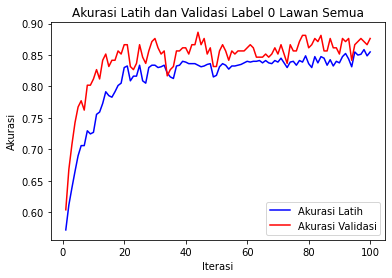

In [90]:
# plot acc train, acc val

plt.plot(iter_history, train_history, color='blue', label='Akurasi Latih')
plt.plot(iter_history, val_history, color='red', label='Akurasi Validasi')

plt.ylabel('Akurasi')
plt.xlabel('Iterasi')
plt.title("Akurasi Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

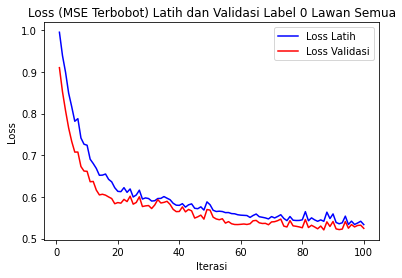

In [91]:
# plot loss train, loss val

plt.plot(iter_history, train_loss_history, color='blue', label='Loss Latih')
plt.plot(iter_history, val_loss_history, color='red', label='Loss Validasi')

plt.ylabel('Loss')
plt.xlabel('Iterasi')
plt.title("Loss (MSE Terbobot) Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

In [92]:
train_val_acc_hist = np.concatenate((train_history.reshape(-1,1), val_history.reshape(-1,1)), axis=1)
train_val_loss_hist = np.concatenate((train_loss_history.reshape(-1,1), val_loss_history.reshape(-1,1)), axis=1)

In [93]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt, loadtxt

def save_to_csv(data, file_name):
    # save to csv file
    savetxt(file_name, data, delimiter=',')
    
def load_from_csv(file_name):
    # load from csv file
    return loadtxt(file_name, delimiter=',')

In [94]:
save_to_csv(train_val_acc_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/acc_hist_8_features_1.txt")
save_to_csv(train_val_loss_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/loss_hist_8_features_1.txt")

In [95]:
# Compute predictions on train and validation set
predictions_test = [np.sign(variational_classifier(var, angles=f)) for f in feats_test]

# Compute accuracy on train and validation set
acc_test = accuracy(Y_test, predictions_test)

test_loss = cost(var, feats_test, Y_test)

print(acc_test, test_loss)

0.8194444444444444 0.563236537811076


In [305]:
def confusion_matrix(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    return CM

In [306]:
confusion_matrix(Y_test, predictions_test)

tensor([[89,  8],
        [ 1,  2]], requires_grad=True)